In [2]:
import pickle, os
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import keras

Using TensorFlow backend.
/Users/charles/anaconda/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/charles/anaconda/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/charles/anaconda/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/charles/anaconda/envs/

# Data Importation and test-valid-train split

In [3]:
#
# Data importation
#
print('Loading data...')
X = np.load('../data/excellent_unoriented/obs.npy')
y = np.load("../data/excellent_unoriented/array_labels.npy")

nb_class = 27

X_synth = np.load('../data/mixed_synthetic/signal_synthetic.npy')
y_synth = np.load('../data/mixed_synthetic/fractions_synthetic.npy')

#
# Train-Test split
#
X_i, X_test, y_i, y_test = train_test_split(np.vstack((X,X_synth)), np.vstack((y,y_synth)), test_size=0.20, random_state=42, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_i, y_i, test_size=0.20, random_state=42, shuffle=True)


#
# Reshaping
# we need to expand to have 3D tensors as input of the 1D CNN

X_train = np.expand_dims(X_train, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print('Shape is {}'.format(X_train.shape))
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')



Loading data...
Shape is (845, 1000, 1)
845 train sequences
265 test sequences


# Building model

In [22]:
#%%
print('Build model...')
model = Sequential()

# create the model
model.add(Conv1D(16,8,activation='relu',kernel_initializer='glorot_uniform',input_shape=(X_train.shape[1],1)))
model.add(MaxPooling1D())
model.add(Dropout(0.2))

model.add(Conv1D(4,2,activation='relu',kernel_initializer='glorot_uniform'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(100, activation='relu'))

model.add(Dense(nb_class, activation='softmax'))


Build model...


# Initialize model

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 993, 16)           144       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 496, 16)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 496, 16)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 495, 4)            132       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 247, 4)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 247, 4)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 988)               0         
__________

# Fit

In [34]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=8,callbacks=[early_stopping])

Train on 845 samples, validate on 212 samples
Epoch 1/100
845/845 [==============================] - 2s 3ms/step - loss: 0.0605 - acc: 0.9173 - val_loss: 0.0683 - val_acc: 0.9174
Epoch 2/100
845/845 [==============================] - 2s 2ms/step - loss: 0.0603 - acc: 0.9173 - val_loss: 0.0669 - val_acc: 0.9179
Epoch 3/100
845/845 [==============================] - 2s 3ms/step - loss: 0.0599 - acc: 0.9172 - val_loss: 0.0684 - val_acc: 0.9174
Epoch 4/100
845/845 [==============================] - 2s 2ms/step - loss: 0.0599 - acc: 0.9172 - val_loss: 0.0680 - val_acc: 0.9168
Epoch 5/100
845/845 [==============================] - 2s 3ms/step - loss: 0.0596 - acc: 0.9176 - val_loss: 0.0669 - val_acc: 0.9172
Epoch 6/100
845/845 [==============================] - 2s 3ms/step - loss: 0.0598 - acc: 0.9175 - val_loss: 0.0673 - val_acc: 0.9175
Epoch 7/100
845/845 [==============================] - 2s 2ms/step - loss: 0.0587 - acc: 0.9176 - val_loss: 0.0668 - val_acc: 0.9179
Epoch 8/100
845/845 [==

# Evaluation on test subset

In [25]:
scores_train = model.evaluate(X_train, y_train, verbose=0)
print("Train accuracy: %.2f%%" % (scores_train[1]*100))
scores_valid = model.evaluate(X_valid, y_valid, verbose=0)
print("Valid accuracy: %.2f%%" % (scores_valid[1]*100))
scores_test = model.evaluate(X_test, y_test, verbose=0)
print("TestAccuracy: %.2f%%" % (scores_test[1]*100))

Train accuracy: 91.78%
Valid accuracy: 91.75%
TestAccuracy: 91.68%


# On observations

In [31]:
X_observed = np.load("./data/To_Recognize/obs.npy")
X_observed = np.expand_dims(X_observed, axis=2)

prediction_obs = model.predict_proba(X_observed)

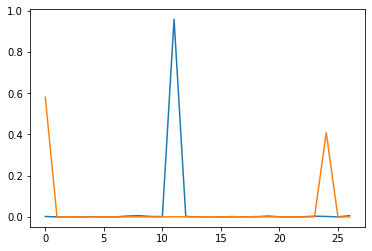

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(prediction_obs[0,:])

plt.plot(prediction_obs[3,:])

plt.ylabel("Class")
plt.yticks()